In [3]:
import pandas as pd
import numpy as np


In [4]:
trade_bra = pd.read_csv('data/econ_data/trade_bra.csv', dtype = {'HS ID 4': str}).dropna(subset = ['Exports', 'Imports'])
wages_bra = pd.read_csv('data/econ_data/wages_bra.csv').dropna(subset = ['Total Jobs', 'Total Yearly Wages'])
trade_chi = pd.read_csv('data/econ_data/trade_chi.csv', dtype = {'HS ID 4': str})
prod_chi = pd.read_csv('data/econ_data/wages_output_chi.csv')#.dropna(subset = ['Total Jobs', 'Total Yearly Wages'])

data_bugs = list(trade_chi.loc[trade_chi['HS ID 6'].str[-1] == ','].index)
trade_chi = trade_chi.drop(data_bugs)

IOError: File data/trade_bra.csv does not exist

In [3]:

# Columns of the datasets
# Geo_cat = ['CHI ID COM']
# HS_cat = ['HS ID 6']
# ind_cat = ['CIIU ID 4']

# Columns of the datasets
Geo_cat = ['BRA ID MIR']
HS_cat = ['HS ID 4']
ind_cat = ['CNAE ID C', 'CBO ID F']

var = 'Total Yearly Wages' # 'output_USD'
var_str = '_w'
var_lab_str = 'Wages in '# 'Output of ' #'Wages in '

def filter_small_cats(df, level, Geo_cat, col):
    grouped = df.groupby(Geo_cat).sum().sort_values(by = col, ascending = False).dropna()
    cumsum = grouped.div(grouped.sum()).cumsum()
    label_sel = cumsum.loc[cumsum[col] < level].index.values
    df_ = df.loc[df[Geo_cat].isin(label_sel)]
    return df_

# df1 = filter_small_cats(wages_bra, .98, 'BRA ID MIR')
# df2 = filter_small_cats(df1, .98, 'CNAE ID C')
# df3 = filter_small_cats(df2, .98, 'CBO ID F')
# wages_bra = df3

df = filter_small_cats(wages_bra, .98, Geo_cat[0], var) #BRA ID MIR
df = filter_small_cats(df, .98, ind_cat[0], var)
df = filter_small_cats(df, .98, ind_cat[1], var)
wages_bra = df

## Info of aggregations

In [4]:
# Load info
path = 'data/disagg_struct_refs/formatted/'

CIIU = pd.read_csv(path+'CIIU_full.csv')
CBO = pd.read_csv(path+'CBO_full.csv').astype(str)
CNAE = pd.read_csv(path+'CNAE_full.csv').astype(str)
HS = pd.read_csv(path+'hs_full.csv').astype(str)

#Geographic info

geo_ids = pd.concat([wages_bra['BRA ID MIR'], trade_bra['BRA ID MIR']]).unique()
GEO_bra = pd.DataFrame([[gid[:3],gid[:5],gid]  for gid in geo_ids], columns = ['BRA ID ST', 'BRA ID MER', 'BRA ID MIR'])
GEO_bra.to_csv('data/disagg_struct_refs/formatted/GEO_bra.csv', index = False)

GEO_chi = pd.read_csv(path+'GEO_chi.csv')[['reg_id', 'prov_id', 'comuna_id']]
GEO_chi = GEO_chi.rename({'reg_id':'CHI ID REG', 'prov_id':'CHI ID PRO', 'comuna_id':'CHI ID COM'},axis = 1)


In [5]:
# Aggregate across 4 years

trade_bra_4y = trade_bra.groupby([u'BRA ID MIR', u'HS ID 4']).sum().reset_index()
wages_bra_4y = wages_bra.groupby([ u'BRA ID MIR',u'CNAE ID C', u'CBO ID F']).sum().reset_index()


In [23]:
nod_df_REG = ['data/correlations/CHI_REG_1_1_1_w_log_corr.csv',
 'data/correlations/CHI_REG_1_2_1_w_log_corr.csv',
 'data/correlations/CHI_REG_1_1_2_w_log_corr.csv',
 'data/correlations/CHI_REG_1_2_2_w_log_corr.csv',
 'data/correlations/CHI_REG_2_1_2_w_log_corr.csv',
 'data/correlations/CHI_REG_2_2_2_w_log_corr.csv',
 'data/correlations/CHI_REG_2_4_2_w_log_corr.csv',
 'data/correlations/CHI_REG_4_4_2_w_log_corr.csv',
 'data/correlations/CHI_REG_4_2_4_w_log_corr.csv',
 'data/correlations/CHI_REG_4_4_4_w_log_corr.csv']
nod_df_PRO = [s.replace('REG', 'PRO') for s in nod_df_REG]
nod_df_COM = [s.replace('REG', 'COM') for s in nod_df_REG]

In [29]:
df_list = [pd.concat([pd.read_csv(f, index_col=0).stack() for f in [nod_df_REG[i], nod_df_PRO[i], nod_df_COM[i]]], axis = 1) for i in range(len(nod_f))]


In [35]:
# 
for df in df_list:
    df = pd.DataFrame(df)
    df.columns = ['REG', 'PRO', 'COM']

In [17]:
nodes_df_list = []
df_list = []

(CBO_lev, CNAE_lev, HS_Exp, HS_Imp) = ('GG', 'S', '2', '2')

    
for Geo_lev in ['ST', 'MER', 'MIR']:
    
    
    trade_bra_4y_gl = trade_bra_4y.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'HS ID 4']).sum().reset_index()
    wages_bra_4y_gl = wages_bra_4y.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'CNAE ID C', 'CBO ID F']).sum().reset_index()

    # Bring 3 datasets and give them node_names. Prepare for correlation

    x = wages_bra_4y_gl.merge(CBO_agg_ref).groupby(['BRA ID '+Geo_lev, 'CNAE ID C', 'CBO ID '+CBO_lev]).sum()[['Total Yearly Wages']].reset_index()
    x = x.merge(CNAE_agg_ref).groupby(['BRA ID '+Geo_lev, 'CNAE ID '+CNAE_lev, 'CBO ID '+CBO_lev]).sum()[['Total Yearly Wages']].reset_index()

    # use label for naming nodes
#     x_ = x.merge(CNAE[['CNAE ID S','CNAE label S']].drop_duplicates())
#     x_ = x_.merge(CBO[['CBO ID GG', 'CBO label GG']].drop_duplicates())
#     x_['node_name'] = 'Wages in ' + x_[[col for col in x_.columns if 'label' in col]].apply(' of '.join, axis=1)

    # use ID for naming nodes
    x_ = x
    x_['node_name'] = 'Wages in ' + x_[[col for col in x_.columns if 'ID' in col and 'BRA' not in col]].apply(' of '.join, axis=1)    
    x_ = x_.drop([col for col in x_.columns if 'label' in col], axis = 1)
    #node size
    x_ = x_.merge(x.groupby(['CNAE ID '+CNAE_lev,'CBO ID '+CBO_lev]).sum().reset_index().rename({'Total Yearly Wages': 'node_size'}, axis = 1))

    x = x_

    x = x.rename({'CNAE ID S': 'att_A', 'CBO ID GG': 'att_B', 'Total Yearly Wages': 'value_USD'}, axis = 1)
    

    # Trade in HS2
    y = trade_bra_4y_gl.merge(HS[['HS ID 4', 'HS ID 2']].drop_duplicates()).groupby(['BRA ID '+Geo_lev, 'HS ID '+HS_Exp]).sum().reset_index()

    y_ = y.merge(HS[['HS ID '+HS_Exp,'HS label '+HS_Exp]].drop_duplicates())
    y_['node_name'] = 'Exports of ' + y_[[col for col in y_.columns if 'label' in col]].apply(' of '.join, axis=1)
    y_ = y_.drop([col for col in y_.columns if 'label' in col], axis = 1)
    y_ = y_.merge(y.groupby(['HS ID '+HS_Exp]).sum().reset_index().rename({'Exports': 'node_size'}, axis = 1),  on = 'HS ID '+HS_Exp)

    y = y_
    y = y.rename({'HS ID '+HS_Exp: 'att_A', 'Exports': 'value_USD'}, axis = 1)
    y['att_B'] = y['att_A']

    z = trade_bra_4y_gl.merge(GEO_bra).merge(HS[['HS ID 4', 'HS ID 2']].drop_duplicates()).groupby(['BRA ID '+Geo_lev, 'HS ID '+HS_Exp]).sum().reset_index()

    z_ = z.merge(HS[['HS ID '+HS_Exp,'HS label '+HS_Exp]].drop_duplicates())
    z_['node_name'] = 'Imports of ' + z_[[col for col in z_.columns if 'label' in col]].apply(' of '.join, axis=1)
    z_ = z_.drop([col for col in z_.columns if 'label' in col], axis = 1)
    z_ = z_.merge(z.groupby(['HS ID '+HS_Imp]).sum().reset_index().rename({'Imports': 'node_size'}, axis = 1), on = 'HS ID '+HS_Imp)

    z = z_
    z = z.rename({'HS ID '+HS_Exp: 'att_A', 'Imports': 'value_USD'}, axis = 1)
    z['att_B'] = z['att_A']

    #Save nodes info
    nodes_df_list += [pd.concat([x, y, z]).groupby('node_name').first()[['att_A', 'att_B', 'node_size']]]

    #Data for correlation
    df = pd.concat([x, y, z]).groupby(['BRA ID '+Geo_lev, 'node_name']).sum()[['value_USD']]
    # functions.drop_small_cats(concat_data, .95)
    df = df.unstack()
    df.columns = df.columns.droplevel(0)


    # correlations
    robust_th = 8
    corr_geolevel_yr = np.log10(df).corr(min_periods = robust_th)
    del corr_geolevel_yr.index.name
    del corr_geolevel_yr.columns.name

    df_list += [pd.DataFrame(corr_geolevel_yr.stack(), columns = ['corr_'+Geo_lev+'_S_GG_2_2'])]
    


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:70: RuntimeWarning: divide by zero encountered in log10


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

data/correlations/CHI_1_1_1_w_log_corr.csv


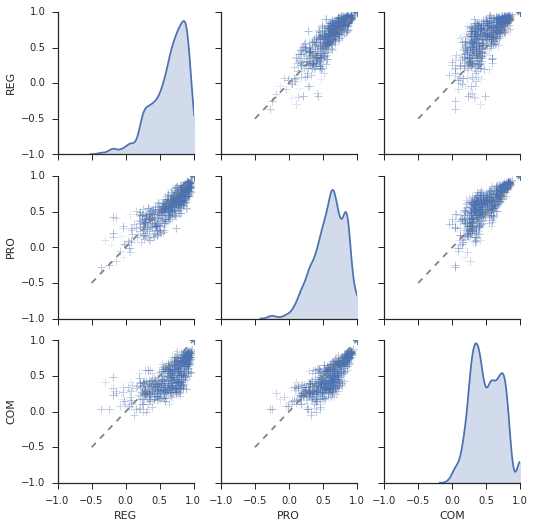

data/correlations/CHI_1_2_1_w_log_corr.csv


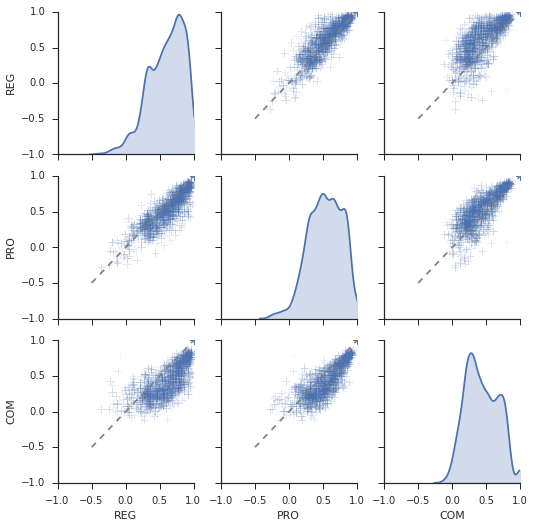

data/correlations/CHI_1_1_2_w_log_corr.csv


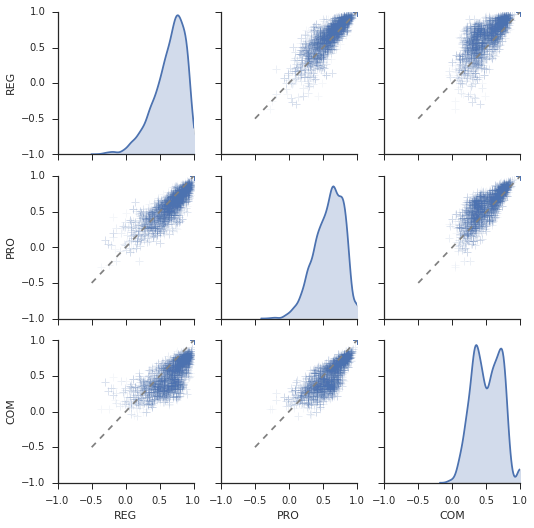

data/correlations/CHI_1_2_2_w_log_corr.csv


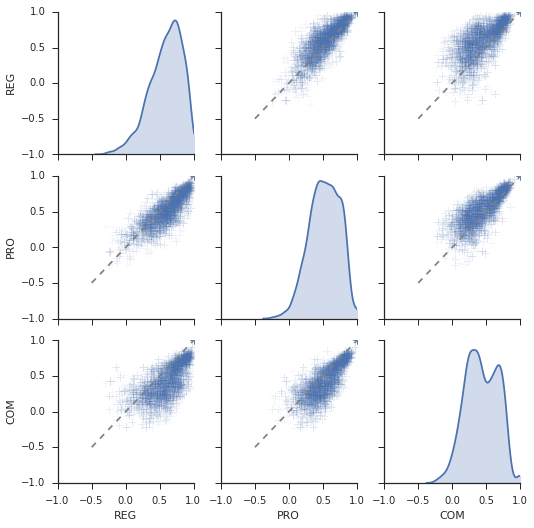

data/correlations/CHI_2_1_2_w_log_corr.csv


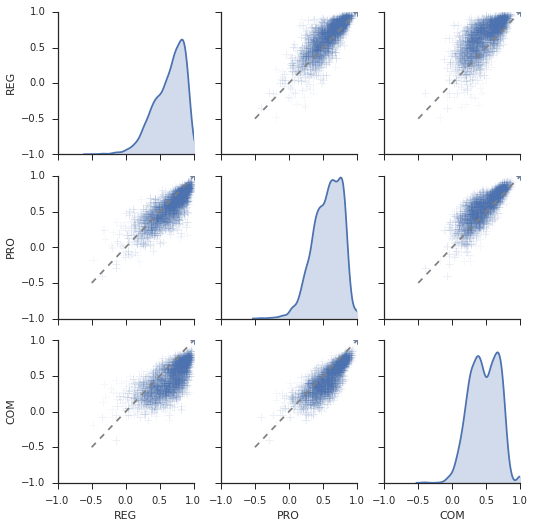

data/correlations/CHI_2_2_2_w_log_corr.csv


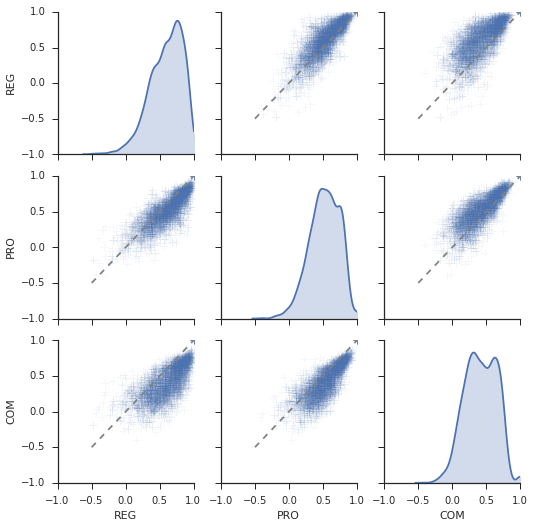

data/correlations/CHI_2_4_2_w_log_corr.csv


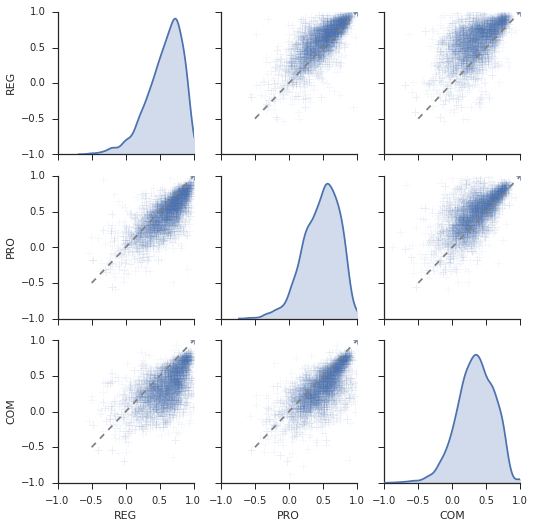

data/correlations/CHI_4_4_2_w_log_corr.csv


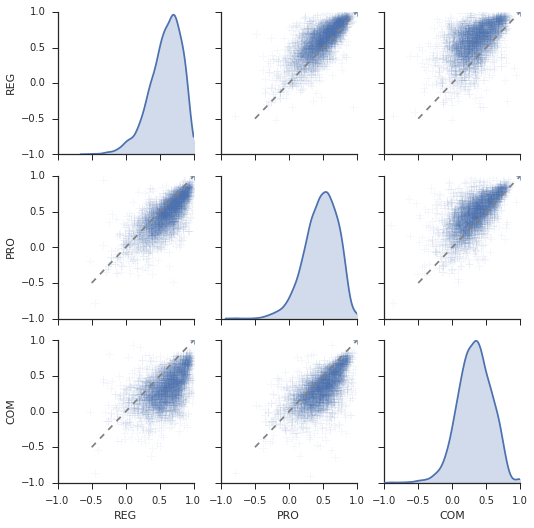

data/correlations/CHI_4_2_4_w_log_corr.csv


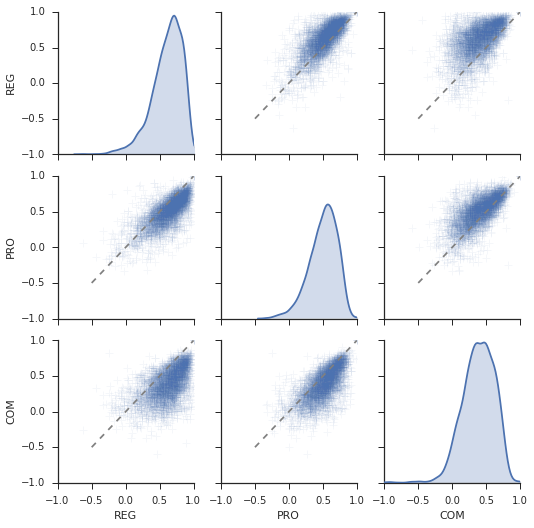

data/correlations/CHI_4_4_4_w_log_corr.csv


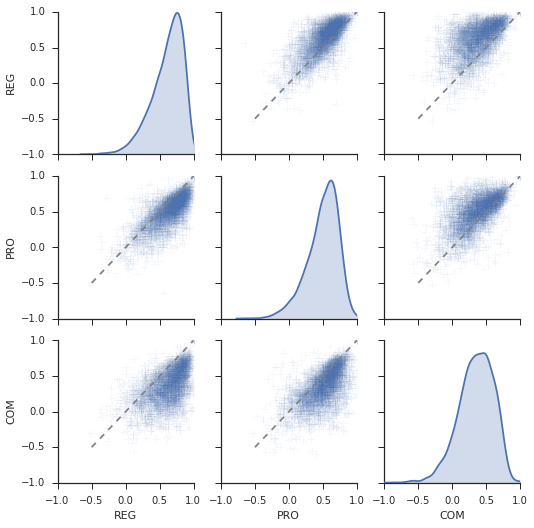

In [51]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# df = pd.concat(df_list, axis = 1).dropna()
for k in range(len(df_list)):
    df = df_list[k]

    print nod_df_REG[k].replace('REG_', '')

    pp = sns.pairplot(df.sample(4000, replace = True), diag_kind="kde", markers="+",
                 plot_kws=dict(s=50, edgecolor="b", linewidth=1, alpha = .05),
                 diag_kws=dict(shade=True))
    [[ax.set_ylim(-1,1) for ax in ax_list] for ax_list in pp.axes]
    [[ax.set_xlim(-1,1) for ax in ax_list] for ax_list in pp.axes]
    x = [-.5, 1]
    [[pp.axes[i][j].plot(x,x, c = '.5', linestyle = '--') for i in range(3) if j != i]for j in range(3)]

    plt.show()